In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
from HySpecLab.metrics import rmse, sad
from scipy import io as sio

In [2]:
from dataset import Cuprite

dataset = Cuprite(config.Cuprite_PATH)
result_path = os.path.join(config.RESULTS_PATH, 'cuprite')

# Ground Truth

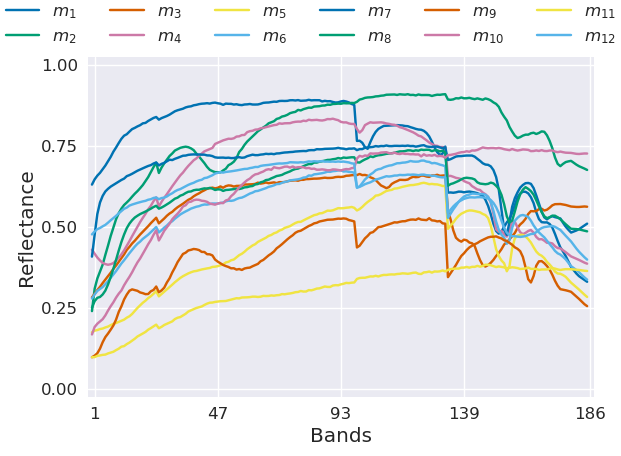

In [3]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), ticks_range=(0, 1))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_ref.pdf'), bbox_inches='tight')

# fig = show_abundance(dataset.abundance())
# plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/A_ref.png'), dpi=300, bbox_inches='tight')

In [4]:
from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return e_idx, sad_result

[ 0  2  4  6  7  8 11]


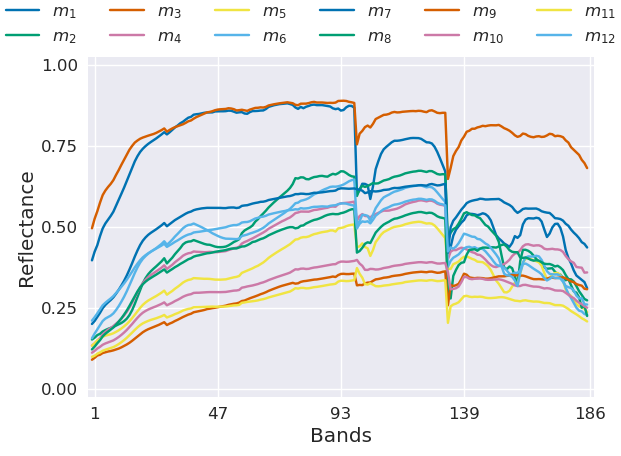

In [5]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
   
vca = VCA(n_endmembers, snr_input=30, random_state=42)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()
e_idx, sad_result = sort_endmember(endmembers, dataset.endmembers())
print(np.unique(e_idx))

vca_endmember_init = endmembers
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, ticks_range=(0, 1))
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'imgs/M_vca.pdf'), bbox_inches='tight')

[ 0  1  3  4  5  7  8  9 10]


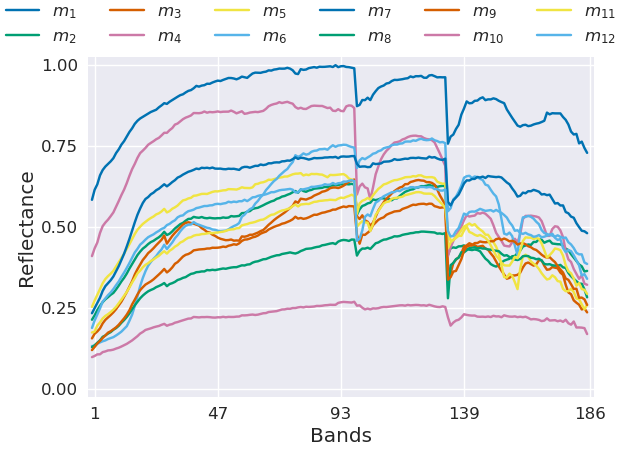

In [6]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

e_idx, _ = sort_endmember(endmember, dataset.endmembers())
# e_idx[2] = 3
print(np.unique(e_idx))
nfindr_endmember_init = endmember
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init + 1e-12) / ((1-nfindr_endmember_init) + 1e-12))

fig = plot_endmembers(nfindr_endmember_init, ticks_range=(0, 1))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_nfindr.pdf'), bbox_inches='tight')

# PPI

In [7]:
ee = eea.PPI()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()



[ 0  1  2  3  6  7  9 10]


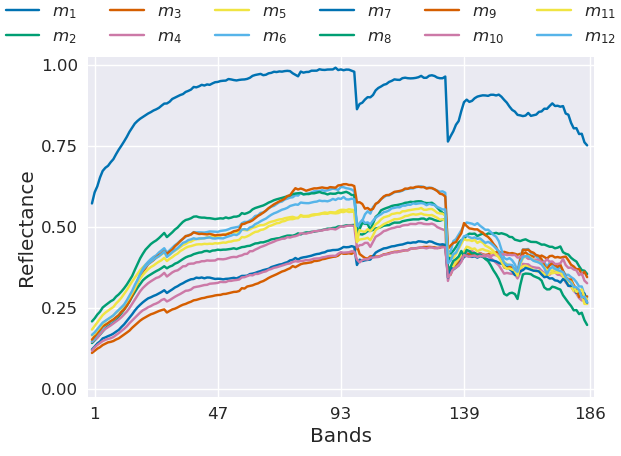

FileNotFoundError: [Errno 2] No such file or directory: '/media/abian/Extreme SSD/Thesis/CLHU/review/cuprite/imgs/M_ppi.pdf'

In [8]:
ppi_endmember_init = endmember
ppi_logit_endmember_init = torch.log((ppi_endmember_init + 1e-12) / ((1-ppi_endmember_init) + 1e-12))
e_idx, _ = sort_endmember(endmember, dataset.endmembers())
print(np.unique(e_idx))

fig = plot_endmembers(ppi_endmember_init, ticks_range=(0, 1))
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/M_ppi.pdf'), bbox_inches='tight')

# ATGP

[ 0  1  2  5  7  8 10 11]


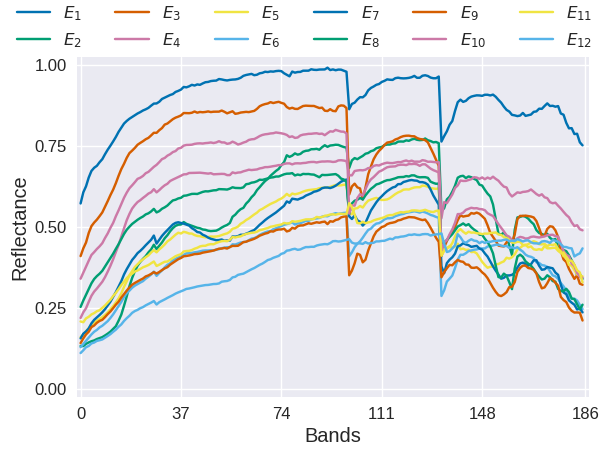

In [ ]:
# ee = eea.ATGP()
# endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

# atgp_endmember_init = endmember
# atgp_logit_endmember_init = torch.log((atgp_endmember_init + 1e-12) / ((1-atgp_endmember_init) + 1e-12))
# e_idx, _ = sort_endmember(endmember, dataset.endmembers())
# print(np.unique(e_idx))

# fig = plot_endmembers(atgp_endmember_init, ticks_range=(0, 1))
# plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_atgp.pdf'), bbox_inches='tight')

In [ ]:
# dict = {'NFINDR': nfindr_endmember_init.numpy(), 'VCA': vca_endmember_init.numpy(), 'PPI': ppi_endmember_init.numpy(),
#         'ATGP': atgp_endmember_init.numpy()}
# sio.savemat(os.path.join(result_path, 'matlab/endmembers.mat'), dict)

In [ ]:
endmember_init_method = 'nfindr'
endmember_init = nfindr_endmember_init
logit_endmember_init = nfindr_logit_endmember_init

# endmember_init_method = 'vca'
# endmember_init = vca_endmember_init
# logit_endmember_init = vca_logit_endmember_init

# endmember_init_method = 'ppi'
# endmember_init = ppi_endmember_init
# logit_endmember_init = ppi_logit_endmember_init

# endmember_init_method = 'atgp'
# endmember_init = atgp_endmember_init
# logit_endmember_init = atgp_logit_endmember_init

In [ ]:
import numpy as np
import torch

from torch.nn import Parameter
from torch.nn import functional as F

    
class GaussianSparseness(nn.Linear):
    def __init__(self, in_features: int, sigma:float=.5) -> None:
        super(GaussianSparseness, self).__init__(in_features, 1, True)
        self.sigma = sigma
        self.__mu = None

    def forward(self, x):
        self.__mu = F.sigmoid(F.linear(x, self.weight, self.bias)) 
        eps = torch.normal(0, torch.ones_like(self.__mu))
        prob = self.__mu + (self.sigma * eps * self.training)
        return F.hardtanh(prob, 0, 1)
    
    def regularize(self):
        r'''
            The expected regularization is the sum of the probabilities 
            that the gates are active
        '''
        # return torch.mean(self._guassian_cdf(1-self.__mu, self.sigma))
        return torch.mean(self._guassian_cdf(self.__mu, self.sigma))
        
    def _guassian_cdf(self, mu:torch.Tensor, sigma:float) -> torch.Tensor:
        r''' 
            Guassian CDF
            
            Based on: https://stackoverflow.com/questions/809362/how-to-calculate-cumulative-normal-distribution

            Parameters
            ----------
            mu: torch.Tensor, shape (in_features,)
                The mean of the Guassian
            
            sigma: float
                The standard deviation of the Guassian
        '''
        return .5 * (1 + torch.erf(mu / (sigma*np.sqrt(2))))
    
    def variational_parameter(self):
        return self.__mu
    
    def __repr__(self):
        return f'GaussianSparseness(in_features={self.in_features}, sigma={self.sigma:.2f})'

In [ ]:
import torch 
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

from collections import deque
from itertools import islice

def lmm(A: torch.Tensor, E: torch.Tensor) -> torch.Tensor:
    '''
        Linear Mixing Model, linear combination of endmembers.

        Args:
        -----
            A: Tensor, shape (bs, n_endmembers)
                Abundance matrix of the linear mixing model.
            E: Tensor, shape (n_endmembers, n_bands)
                Endmembers.
    '''
    bs, _ = A.shape
    return torch.bmm(A.unsqueeze(1), E.unsqueeze(0).expand(bs, -1, -1)).squeeze()

## General
def slide(iterable, size):
    '''
        Iterate through iterable using a sliding window of several elements.
        Important: It is a generator!.
        
        Creates an iterable where each element is a tuple of `size`
        consecutive elements from `iterable`, advancing by 1 element each
        time. For example:
        >>> list(sliding_window_iter([1, 2, 3, 4], 2))
        [(1, 2), (2, 3), (3, 4)]
        
        source: https://codereview.stackexchange.com/questions/239352/sliding-window-iteration-in-python
    '''
    iterable = iter(iterable)
    window = deque(islice(iterable, size), maxlen=size)
    for item in iterable:
        yield tuple(window)
        window.append(item)
    if window:  
        # needed because if iterable was already empty before the `for`,
        # then the window would be yielded twice.
        yield tuple(window)

class ContrastiveUnmixing(nn.Module):
    def __init__(self, n_bands, n_endmembers, encode_layers=[512, 128, 32], endmember_init=None, sparsity=.5) -> None:
        super(ContrastiveUnmixing, self).__init__()      
        encode_layers = [n_bands] + encode_layers
        self.n_endmembers = n_endmembers
        # Encoder
        encoder = []
        for idx, test in enumerate(slide(encode_layers, 2)):
            encoder.append(self.__encode_layer(*test, dropout=True if idx < len(encode_layers)-2 else False))
        self.encoder = nn.Sequential(*encoder)

        # Endmember bank
        self.ebk = Parameter(torch.randn(n_endmembers, n_bands))
        if endmember_init is not None:
            self.ebk.data = endmember_init

        self.sparse_gate = GaussianSparseness(encode_layers[-1], sigma=sparsity)
        
        # Projection layer
        self.projection = nn.Linear(encode_layers[-1], n_bands, bias=False)

        self.A = None

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        z = self.encoder(input)
        r0 = self.projection(z)
        sparse = self.sparse_gate(z)

        self.A = self.__similarity(r0, sparse)
        return lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))

    def __encode_layer(self, in_features, out_features, dropout=False):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            *[nn.ReLU(), nn.Dropout(0.5)] if dropout else [nn.Identity()]
        )

    def __similarity(self, X: torch.Tensor, sparse:torch.Tensor) -> torch.Tensor:
        '''
            Cosine similarity between input and endmember bank.

            Parameters
            ----------
                x: torch.Tensor, shape=(batch_size, n_bands)
                    input tensor.         
        '''
        bs, n_bands = X.shape
        X = normalize(X, dim=1)

        normalize_ebk = normalize(self.ebk.detach(), dim=1).expand(bs, -1, -1)
        cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
        v = (cos*.5) + .5
        eps = 1e-12
        return (1 + eps)/(sparse + eps)*torch.log(v/ (1-v))

        # return torch.exp(self.sparse_gate(self.sparse))*torch.log(v/ (1-v))
        # return torch.pow(self.n_endmembers, self.sparse_gate(self.sparse))*torch.log(v/ (1-v))
        # return self.sparse*torch.exp(v)*torch.log(v/ (1-v))

In [ ]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss
from torch.utils.data import Dataset, DataLoader
from torch import sigmoid, nn
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss
from torch.utils.data import Dataset, DataLoader
from torch import sigmoid, nn
from tqdm import tqdm
import torch

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3, similarity_weight=1, sparse_weight=1e-1):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = UnmixingLoss() 
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    scaler = torch.cuda.amp.GradScaler()

    for _ in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + similarity_weight*similarity_reg(sigmoid(model.ebk)) +  sparse_weight*model.sparse_gate.regularize()
            # loss = criterion(y, x) + similarity_weight*similarity_reg(model.ebk) + sparse_weight/torch.exp(model._sparse).mean()
            epoch_loss += loss.detach().item()

            # loss.backward()
            # optimizer.step()


            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

In [97]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

similarity_reg = SimilarityLoss(n_endmembers, temperature=1e-3, reduction='mean')
similarity_reg(dataset.endmembers()), similarity_reg(endmember_init)

(tensor(0.0800), tensor(0.2344))

# Training

In [219]:
# from utils import train 
# from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sparsity=.05)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, sparse_weight=1)

100%|██████████| 50/50 [00:12<00:00,  3.93epoch/s, tls=1.0310]


In [220]:
model.eval()
print(model.sparse_gate.variational_parameter().flatten())
print(model.sparse_gate.variational_parameter().flatten().mean())
print(model.sparse_gate.variational_parameter().flatten().min())

tensor([0.6515, 0.6053, 0.6935, 0.5142, 0.6268, 0.6459, 0.4511, 0.6586, 0.6009,
        0.5644, 0.6003, 0.6219, 0.5821, 0.5214, 0.5589, 0.6470, 0.6468, 0.6122,
        0.6378, 0.5191, 0.6854, 0.4730, 0.5711, 0.5662, 0.6002, 0.6760, 0.6043,
        0.4301, 0.6491, 0.3141, 0.6504, 0.6161, 0.6614, 0.5235, 0.6166, 0.6516,
        0.6447, 0.6742, 0.6699, 0.6010, 0.6425, 0.6499, 0.6258, 0.4222, 0.6903,
        0.6807, 0.6123, 0.6980, 0.5496, 0.4940, 0.6462, 0.5838, 0.5349, 0.5509,
        0.5584, 0.5438, 0.4309, 0.6303, 0.5869, 0.5852, 0.6774, 0.5759, 0.6716,
        0.5335, 0.6737, 0.6887, 0.6708, 0.6210, 0.5545, 0.6057, 0.5867, 0.4357,
        0.5306, 0.5967, 0.6018, 0.6104, 0.6670, 0.6580, 0.6060, 0.6087, 0.6643,
        0.6815, 0.6861, 0.5592, 0.5828, 0.6257, 0.5867, 0.6324, 0.4439, 0.6009,
        0.5695, 0.5831, 0.6580, 0.5866, 0.6418, 0.6425, 0.4419, 0.6131, 0.6466,
        0.4857, 0.6891, 0.6725, 0.6138, 0.6263, 0.5580, 0.6605, 0.5434, 0.4127,
        0.6638, 0.4942, 0.6831, 0.5320, 

# Save model

In [221]:
# torch.save(model.state_dict(), os.path.join(result_path, 'clhu/weights/clhu_{}.pth'.format(endmember_init_method)))

# Testing model

In [222]:
# load model
# model = ContrastiveUnmixing(dataset.n_bands, dataset.n_endmembers)

# model.load_state_dict(torch.load(os.path.join(result_path, 'clhu/weights/clhu_{}.pth'.format(endmember_init_method))))
model = model.eval()

In [223]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy

criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [224]:
from torch import sigmoid 
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0159) tensor(0.7084) tensor(1.3371e-07) tensor(1.9191)


In [225]:
volume_reg(endmember_init), similarity_reg(endmember_init)

(tensor(1.7213e-15), tensor(2.4001))

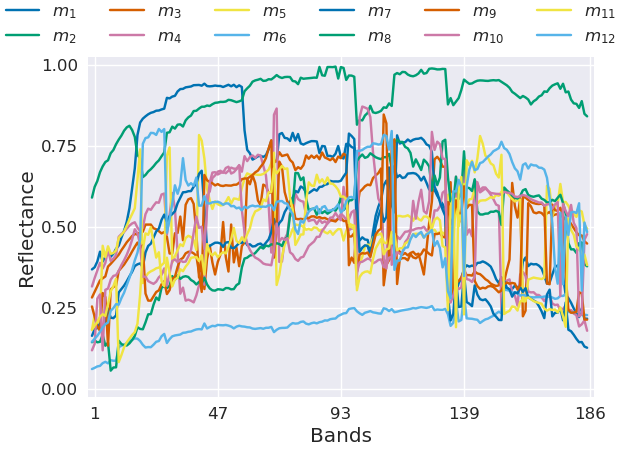

In [226]:
ebk = torch.sigmoid(model.ebk).detach().cpu()

fig = plot_endmembers(ebk, ticks_range=(0, 1))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/imgs/M_clhu_{}.pdf'.format(endmember_init_method)), bbox_inches='tight')

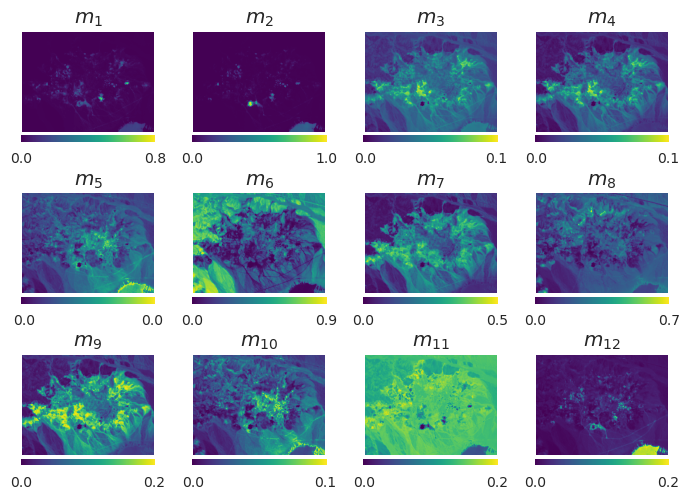

In [227]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

fig = show_abundance(test)
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'clhu/imgs/A_clhu_{}.png'.format(endmember_init_method)), dpi=300, bbox_inches='tight')

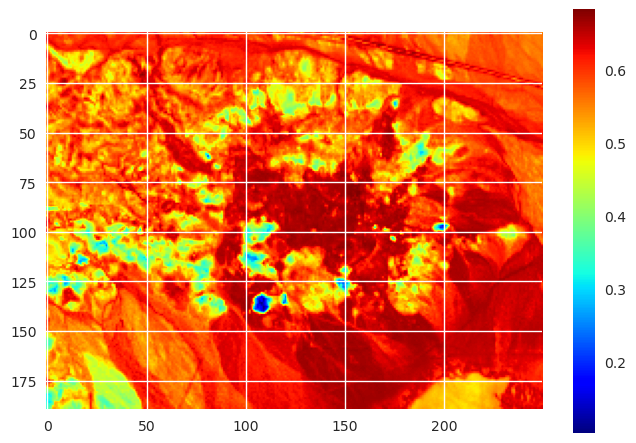

In [229]:
test = model.sparse_gate.variational_parameter().detach().cpu().numpy().reshape(dataset.n_row, dataset.n_col)
plt.imshow(test.T, cmap='jet')
plt.colorbar()
plt.show()

In [230]:
M_hat = torch.sigmoid(model.ebk).detach().cpu()
e_idx, sad_result = sort_endmember(M_hat, dataset.endmembers())
print(len(np.unique(e_idx)))

print(e_idx)
# print(sad_result)
print(sad_result[np.arange(12), e_idx])

# sad_result as df
import pandas as pd
sad_df = pd.DataFrame(sad_result, columns=['E_{}'.format(i) for i in range(1, n_endmembers+1)])
index = ['Ê_{}'.format(i) for i in range(1, n_endmembers+1)]
sad_df.index = index
# sad_df.to_csv(os.path.join(result_path, 'clhu/sad_clhu_{}.csv'.format(endmember_init_method)))

sad_df

4
tensor([0, 1, 1, 1, 7, 1, 1, 1, 1, 5, 5, 1])
tensor([0.1914, 0.1086, 0.2585, 0.3103, 0.2352, 0.1780, 0.3325, 0.2295, 0.2866,
        0.2733, 0.2752, 0.2299])


,E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,E_10,E_11,E_12
Ê_1,0.191370,0.388231,0.302276,0.274437,0.442355,0.319411,0.289986,0.332942,0.370697,0.451317,0.511801,0.265793
Ê_2,0.230466,0.108605,0.140824,0.201772,0.215314,0.147052,0.129788,0.118322,0.171036,0.148775,0.192824,0.130820
Ê_3,0.269445,0.258478,0.207706,0.257738,0.317962,0.255215,0.252522,0.247801,0.279749,0.292659,0.342868,0.235212
Ê_4,0.262588,0.310317,0.310805,0.255136,0.342095,0.268253,0.251665,0.282672,0.329410,0.374613,0.414938,0.246777
Ê_5,0.292329,0.232831,0.244927,0.283214,0.326302,0.257407,0.225952,0.235203,0.276335,0.251141,0.286465,0.224824
Ê_6,0.380807,0.177965,0.234767,0.317377,0.234432,0.249759,0.281338,0.212491,0.219284,0.115943,0.106852,0.292779
Ê_7,0.258017,0.332524,0.283042,0.235927,0.315930,0.256467,0.300677,0.284515,0.273404,0.400369,0.447012,0.282036
Ê_8,0.443348,0.229501,0.313669,0.330948,0.168930,0.272195,0.349182,0.263088,0.233770,0.201793,0.181377,0.358699
Ê_9,0.282559,0.286595,0.251703,0.252124,0.318548,0.259458,0.268004,0.262423,0.305025,0.306331,0.347101,0.253673
Ê_10,0.341533,0.259862,0.263944,0.324089,0.316881,0.273319,0.280454,0.254069,0.262707,0.257428,0.271577,0.278285


In [256]:
sad_result[np.arange(12),e_idx].mean()

tensor(0.1820)

In [257]:
e_idx, sad_result = sort_endmember(endmember_init, dataset.endmembers())
print(len(np.unique(e_idx)))

print(e_idx)
print(sad_result[np.arange(12), e_idx])

import pandas as pd
sad_df = pd.DataFrame(sad_result, columns=['E_{}'.format(i) for i in range(1, n_endmembers+1)])
index = ['Ê_{}'.format(i) for i in range(1, n_endmembers+1)]
sad_df.index = index
sad_df.to_csv(os.path.join(result_path, 'clhu/sad_{}.csv'.format(endmember_init_method)))

sad_df

7
tensor([ 0,  6,  2, 11,  4, 11,  2,  6,  7,  8,  8,  2])
tensor([0.0815, 0.2233, 0.1130, 0.1807, 0.0841, 0.1565, 0.1209, 0.1843, 0.1701,
        0.0833, 0.0851, 0.1337])


,E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,E_10,E_11,E_12
Ê_1,0.081504,0.259152,0.182674,0.148124,0.312475,0.186172,0.167184,0.204794,0.246564,0.331101,0.392001,0.130780
Ê_2,0.274469,0.168383,0.201581,0.141231,0.102728,0.119276,0.223325,0.148011,0.120963,0.220980,0.258838,0.211882
Ê_3,0.175870,0.121862,0.113006,0.170557,0.232761,0.128229,0.089543,0.101187,0.169862,0.181362,0.236174,0.086227
Ê_4,0.255873,0.119407,0.122323,0.145627,0.121620,0.102113,0.190702,0.099474,0.103788,0.152097,0.200144,0.180722
Ê_5,0.269419,0.128489,0.168417,0.157470,0.084067,0.102334,0.200320,0.114918,0.102260,0.172634,0.208720,0.195469
Ê_6,0.197215,0.167173,0.154948,0.103964,0.163829,0.088236,0.172217,0.118626,0.116496,0.239061,0.288695,0.156512
Ê_7,0.234430,0.070802,0.120908,0.160667,0.162769,0.097014,0.143897,0.063315,0.104631,0.116022,0.174147,0.144131
Ê_8,0.239966,0.125255,0.151163,0.141287,0.135544,0.089230,0.184270,0.100904,0.073928,0.171755,0.219415,0.167779
Ê_9,0.356486,0.129564,0.212209,0.260758,0.153722,0.195419,0.255748,0.170071,0.160610,0.067585,0.074136,0.258378
Ê_10,0.263667,0.071608,0.141390,0.162658,0.113773,0.098019,0.175256,0.079102,0.083283,0.111543,0.158925,0.173253


In [150]:
endmember_init_method

'nfindr'